In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import tensorflow as tf
import random

# Parâmetros fixos
IMG_SIZE = (222, 222)

# Função que combina duas listas (geralmente usada para associar imagens com seus rótulos)
def build(a, b):
    return [[a[i], b[i]] for i in range(len(a))]

# Função para embaralhar aleatoriamente a lista de elementos
def shuffle(x):
    random.shuffle(x)
    return x

# Função para carregar e processar imagens
def get_images(images_paths):
    images = []
    for path, _ in images_paths:
        img = Image.open(path).convert('L')
        img = img.resize(IMG_SIZE)
        img_array = np.array(img, dtype='float32') / 255.0  # Converte a imagem para um array numpy e normaliza os valores para [0, 1]
        images.append(img_array.reshape((*IMG_SIZE, 1)))  # Adiciona canal
    return images

# Função para extrair os rótulos (tipos) das imagens
def get_images_types(images_paths):
    return [int(label) for _, label in images_paths]

In [2]:
# Caminhos para as imagens
train_benign_path    = "breast-cancer-detection\\versions\\1\\train\\0"
train_malignant_path = "breast-cancer-detection\\versions\\1\\train\\1"
test_benign_path     = "breast-cancer-detection\\versions\\1\\test\\0"
test_malignant_path  = "breast-cancer-detection\\versions\\1\\test\\1"

In [3]:

train_images_paths = []
test_images_paths = []

# Alimentando a lista conforme os dados obtidos na base de dados do Kaggle
for img in os.listdir(train_benign_path):
    train_images_paths.append([os.path.join(train_benign_path, img), 0])
for img in os.listdir(train_malignant_path):
    train_images_paths.append([os.path.join(train_malignant_path, img), 1])
for img in os.listdir(test_benign_path):
    test_images_paths.append([os.path.join(test_benign_path, img), 0])
for img in os.listdir(test_malignant_path):
    test_images_paths.append([os.path.join(test_malignant_path, img), 1])

In [4]:
# Carregar imagens e rótulos
train_images = get_images(train_images_paths)
train_labels = get_images_types(train_images_paths)
test_images = get_images(test_images_paths)
test_labels = get_images_types(test_images_paths)

# Transformar em arrays
xtrain = np.array(train_images)
ytrain = np.array(train_labels)
xtest = np.array(test_images)
ytest = np.array(test_labels)

In [ ]:
# O Early Stopping interrompe o treinamento se a performance do modelo não melhorar após 5 épocas, evitando o overfitting e economizando tempo de treinamento.
# O ReduceLROnPlateau ajusta dinamicamente a taxa de aprendizado, reduzindo-a pela metade se o modelo não estiver aprendendo mais, o que pode ajudar a atingir uma solução ótima.

# Callbacks: early stopping e redução da taxa de aprendizado
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', # Monitorar a 'loss' (função de erro) no conjunto de validação
    patience=5,
    restore_best_weights=True # Restaurar os pesos do melhor modelo durante o treinamento
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5, # Fator de redução da taxa de aprendizado (reduz pela metade)
    patience=2,
    min_lr=1e-6,
    verbose=1
)

In [ ]:
# Modelo CNN otimizado
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(222, 222, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)), # Reduz a dimensionalidade da imagem pela metade, pegando o máximo de cada bloco 2x2.
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'), # Aplica 64 novos filtros 3x3 sobre a saída da camada anterior, aprendendo padrões mais complexos a partir dos primeiros.
    tf.keras.layers.MaxPooling2D((2, 2)), # reduz a dimensionalidade após a segunda camada convolucional. 
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3), # Dropout de 30% dos neurônios durante o treinamento
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'), # O modelo começa a tomar decisões com base nas características extraídas anteriormente.
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(2, activation='softmax') # transforma as saídas em probabilidades somando 1, e permite que o modelo escolha a classe com maior probabilidade.
])


c:\Users\shado\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [37]:
# Compilar o modelo
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Treinar o modelo
history = model.fit(xtrain, ytrain, epochs=10, validation_data=(xtest, ytest))

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 42s 537ms/step - accuracy: 0.6248 - loss: 0.6842 - val_accuracy: 0.6280 - val_loss: 0.6538
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 40s 533ms/step - accuracy: 0.6753 - loss: 0.6189 - val_accuracy: 0.6161 - val_loss: 0.6798
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 40s 537ms/step - accuracy: 0.6780 - loss: 0.6034 - val_accuracy: 0.6458 - val_loss: 0.6660
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 40s 530ms/step - accuracy: 0.7125 - loss: 0.5608 - val_accuracy: 0.6429 - val_loss: 0.6571
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 37s 490ms/step - accuracy: 0.7328 - loss: 0.5316 - val_accuracy: 0.6310 - val_loss: 0.6712
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 37s 489ms/step - accuracy: 0.7475 - loss: 0.4948 - val_accuracy: 0.6161 - val_loss: 0.7377
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 36s 475ms/step - accuracy: 0.7897 - loss: 0.4463 - val_accuracy: 0.6161 - val_loss: 0.8716
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 38s 505ms/step - accuracy: 0.8362 - loss: 0.3760 - val_accu

In [38]:
# Mostrar estrutura do modelo
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 220, 220, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 108, 108, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │     5,537,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,891,976 (64.44 MB)

 Trainable params: 5,630,658 (21.48 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,261,318 (42.96 MB)

In [43]:
loss, accuracy = model.evaluate(xtest, ytest)
print(f"Acurácia no conjunto de teste: {accuracy*100:.2f}%")


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.7056 - loss: 0.9669
Acurácia no conjunto de teste: 62.80%


In [44]:
# Fazer previsões
y_pred_probs = model.predict(xtest)
y_pred = np.argmax(y_pred_probs, axis=1)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step


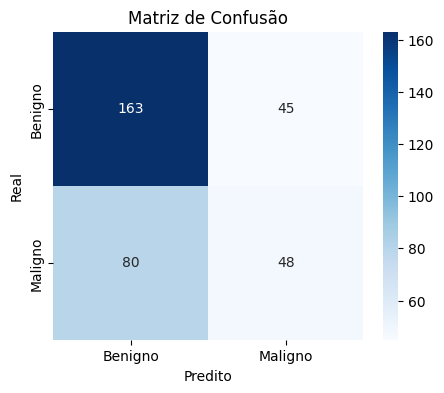

              precision    recall  f1-score   support

     Benigno       0.67      0.78      0.72       208
     Maligno       0.52      0.38      0.43       128

    accuracy                           0.63       336
   macro avg       0.59      0.58      0.58       336
weighted avg       0.61      0.63      0.61       336



In [45]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Matriz de confusão
cm = confusion_matrix(ytest, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Benigno", "Maligno"], yticklabels=["Benigno", "Maligno"])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

# Relatório de classificação
print(classification_report(ytest, y_pred, target_names=["Benigno", "Maligno"]))


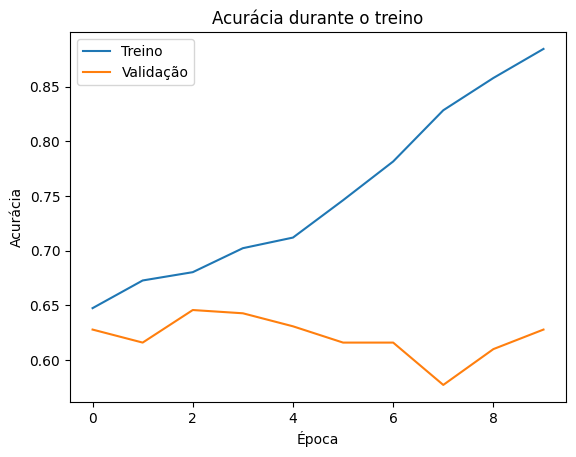

In [46]:
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia durante o treino')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.show()